## Setup and data read

In [1]:
# Imports and parameter setting
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as Funcs

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn import ensemble

import pandas as pd
import numpy as np
import cPickle as pickle

pd.set_option("display.max_columns", 100)

inputPath = '/home/jovyan/work/data/autot4.7.csv'

# Create a spark session
session = SparkSession \
    .builder \
    .appName("Car data") \
    .config('spark.driver.memory', '5G') \
    .config('spark.executor.memory', '5G') \
    .getOrCreate()
    


In [2]:
# Read input data into a spark data frame
# remove . from column names
inDf = session.read \
    .format("org.apache.spark.csv") \
    .option("header", "true") \
    .option("delimiter", ";") \
    .option("mode", "DROPMALFORMED") \
    .csv(inputPath)
    
newColnames = [col.replace('.','_',5) for col in inDf.columns]
inDf = inDf.toDF(*newColnames)

In [3]:
#Select a subset of columns and set their types 
carsDf = inDf.select(
    'ajoneuvoluokka',
    'ajoneuvonkaytto',
    'ajoneuvoryhma',
    'korityyppi',
    'ohjaamotyyppi',
    'kayttovoima',
    'istumapaikkojenLkm',
    'sylintereidenLkm',
    'vaihteisto',
    'alue',
    'kunta',
    'merkki',
    'malli',
    'merkki_l_malli',
    'kayttoonotto_pvm_imputoitu',
    inDf['omamassa'].cast("int"),
    inDf['iskutilavuus'].cast("int"),
    inDf['suurinNettoteho'].cast("int"),
    inDf['matkamittarilukema'].cast("int"),
    inDf['kayttoonottoVuosi'].cast("int"),
    inDf['ensirekVuosi'].cast("int"),
    inDf['ensirekisterointipvm'].cast("timestamp"),
    inDf['kayttoonottopvm'].cast("timestamp"),
    inDf['max_date'].cast("timestamp"),
    inDf['kayttoonotto'].cast("timestamp")
)
# List of variables by types strings are called 'factors'
factorVars = [
    'ajoneuvoluokka',
    'ajoneuvonkaytto',
    'ajoneuvoryhma',
    'korityyppi',
    'ohjaamotyyppi',
    'kayttovoima',
    'istumapaikkojenLkm',
    'sylintereidenLkm',
    'vaihteisto',
    'alue',
    'kunta',
    'merkki',
    'malli',
    'merkki_l_malli',
    'kayttoonotto_pvm_imputoitu'
]
numericVars = [
    'omamassa',
    'iskutilavuus',
    'suurinNettoteho',
    'matkamittarilukema',
    'kayttoonottoVuosi',
    'ensirekVuosi'
]
dateVars = [
    'ensirekisterointipvm',
    'kayttoonottopvm',
    'max_date',
    'kayttoonotto'
]


In [4]:
# Calculate new columns from original
carsDf = carsDf.withColumn(
    'usageDays', 
    (carsDf['max_date'].cast('long')-carsDf['kayttoonottopvm'].cast('long'))/(24.0 * 3600.0)
)
numericVars.append('usageDays')

carsDf = carsDf.withColumn(
    'mileagePerDay', 
    carsDf['matkamittarilukema'].cast('float')/carsDf['usageDays']
)
numericVars.append('mileagePerDay')

# Truncate values to sensible values
carsDf = carsDf.withColumn(
    'mileagePerDay', 
    Funcs.when(carsDf['mileagePerDay']>200, 200).otherwise(carsDf['mileagePerDay'])
)
# Or filter out unsensible values (car mass)
carsDf = carsDf.filter(carsDf.omamassa.between(1, 4000))

carsDf = carsDf.filter(carsDf.matkamittarilukema.between(1e4, 1e6))

#Only cars that are still in use and data has been collected
carsDf = carsDf.filter(carsDf.kayttoonottoVuosi.between(1990, 2011))

# Imputation gives strange results
carsDf = carsDf.filter(carsDf.kayttoonotto_pvm_imputoitu == 0)

## Preprocess for modeling

In [5]:
# split data into training (20%), test (10%) and rest (70%) sets
# numbers are chosen here for convenience, 20% of this set is enought to fit model
splits = carsDf.randomSplit([0.1, 0.1, 0.8], 220274)

In [6]:
# Get modelling data to pandas data frame
modelDf = splits[0].toPandas()

In [7]:
# Get test data into pandas DF
# testDf = splits[1].toPandas()

In [8]:
# Some more filtering
modelDf = modelDf[
    (modelDf.ajoneuvonkaytto == 'Yksityinen') &
    (modelDf.ajoneuvoryhma.isin(['NA', 'Matkailuauto', 'Maastohenkilöauto']))
]         


In [9]:
# numeric and factor type variables are treated differently

# first pick numerical variables into training data
trainDf = modelDf[numericVars]

# remove target variable into separate vector
trainDf.pop('mileagePerDay')
target = trainDf.pop('matkamittarilukema')
target = np.log(target)


# numerical data has missing values, replace missing with average of that variable
# Good idea: make additional variable for denoting that the value was missing
imputer = Imputer()
XImputed = imputer.fit_transform(trainDf)

# scale numerical variables to zero mean and unit variance
scaler = StandardScaler()
XScaled = scaler.fit_transform(XImputed)

# put model fitting data into pandas data frame
X = pd.DataFrame(XScaled, columns=trainDf.columns, index=trainDf.index)
X.head()

,omamassa,iskutilavuus,suurinNettoteho,kayttoonottoVuosi,ensirekVuosi,usageDays
332,3.284930,1.897064,0.068967,0.474122,0.474131,-0.464951
333,3.386719,1.658516,0.735873,-0.144894,-0.144888,0.237349
334,3.386719,1.658516,0.735873,-0.144894,-0.144888,0.143069
335,1.486659,1.042268,-1.106058,-2.414623,-2.414627,2.467322
336,4.099242,1.221179,0.481813,0.886800,0.886811,-0.809891


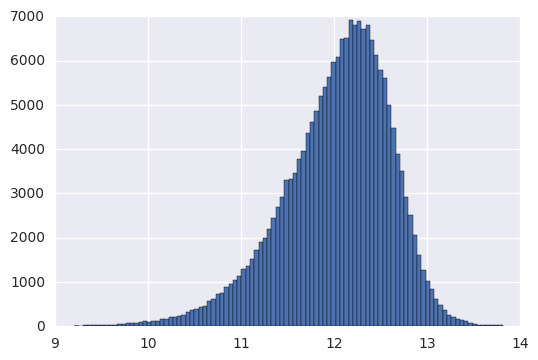

In [10]:
target.hist(bins=100)

In [11]:
# factor variables are included through dummy variable encoding
vars = ['ajoneuvoryhma', 'kayttovoima', 'vaihteisto', 'istumapaikkojenLkm', 'ohjaamotyyppi', 'korityyppi']
for c in vars:
    tmp = pd.get_dummies(modelDf[c], prefix=c)
    # add dummy variables to fitting data
    X[tmp.columns] = tmp

print(X.shape)
X.head()    

(193845, 50)


,omamassa,iskutilavuus,suurinNettoteho,kayttoonottoVuosi,ensirekVuosi,usageDays,ajoneuvoryhma_Matkailuauto,ajoneuvoryhma_NA,kayttovoima_Bensiini,kayttovoima_Bensiini/CNG,kayttovoima_Bensiini/Etanoli,kayttovoima_Bensiini/Sähkö,kayttovoima_CNG,kayttovoima_Dieselöljy,kayttovoima_Etanoli (E85),kayttovoima_Sähkö,vaihteisto_Automaattinen,vaihteisto_Käsivalintainen,vaihteisto_Käsivalintainen/automaattinen,vaihteisto_Portaaton,istumapaikkojenLkm_1,istumapaikkojenLkm_2,istumapaikkojenLkm_3,istumapaikkojenLkm_4,istumapaikkojenLkm_5,istumapaikkojenLkm_56,istumapaikkojenLkm_6,istumapaikkojenLkm_7,istumapaikkojenLkm_8,istumapaikkojenLkm_9,istumapaikkojenLkm_NA,ohjaamotyyppi_Avo-ohjaamo,ohjaamotyyppi_Jatko-ohjaamo,ohjaamotyyppi_NA,ohjaamotyyppi_Suojakehys,ohjaamotyyppi_Umpiohjaamo,korityyppi_AG Tavarafarmari,korityyppi_Ambulanssi (SC),korityyppi_Avoauto (AE),korityyppi_Coupé (AD),korityyppi_Farmari (AC),korityyppi_Matkailuauto (SA),korityyppi_Monikäyttöajoneuvo (AF),korityyppi_Muut erikoiskäyttöön tarkoitetut ajoneuvot (SG),korityyppi_NA,korityyppi_Pyörätuolin käyttäjälle tarkoitettu ajoneuvo (SH),korityyppi_Sedan (AA),korityyppi_Umpi/avo,korityyppi_Umpikorinen (BB),korityyppi_Viistoperä (AB)
332,3.284930,1.897064,0.068967,0.474122,0.474131,-0.464951,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
333,3.386719,1.658516,0.735873,-0.144894,-0.144888,0.237349,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
334,3.386719,1.658516,0.735873,-0.144894,-0.144888,0.143069,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
335,1.486659,1.042268,-1.106058,-2.414623,-2.414627,2.467322,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
336,4.099242,1.221179,0.481813,0.886800,0.886811,-0.809891,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## Model fitting


### Linear model
Fit a linear model to the data. Fitting done with elastic-net algorithm
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet.fit

In [12]:
# for now, just using the default parameters (usually not enough)
enet = ElasticNet()
enet.fit(X, target)

# print results
pd.Series(enet.coef_, index=X.columns)

omamassa                                                        0.0
iskutilavuus                                                    0.0
suurinNettoteho                                                 0.0
kayttoonottoVuosi                                              -0.0
ensirekVuosi                                                   -0.0
usageDays                                                       0.0
ajoneuvoryhma_Matkailuauto                                     -0.0
ajoneuvoryhma_NA                                                0.0
kayttovoima_Bensiini                                           -0.0
kayttovoima_Bensiini/CNG                                        0.0
kayttovoima_Bensiini/Etanoli                                   -0.0
kayttovoima_Bensiini/Sähkö                                     -0.0
kayttovoima_CNG                                                -0.0
kayttovoima_Dieselöljy                                          0.0
kayttovoima_Etanoli (E85)                       

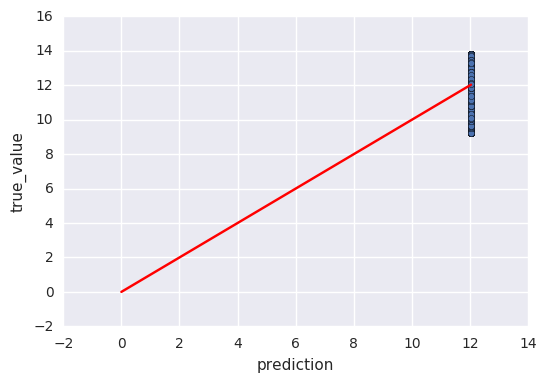

In [13]:
# Plot the prediction vs. true values
plotDf = pd.DataFrame({'prediction': enet.predict(X), 'true_value': target})
plotDf['residual'] = plotDf.true_value-plotDf.prediction
zz = np.array([0, plotDf.prediction.max()])
#fig, axes = plt.subplots()
plotDf.plot.scatter(x='prediction', y='true_value')
plt.plot(zz, zz, 'r-')
plt.show()

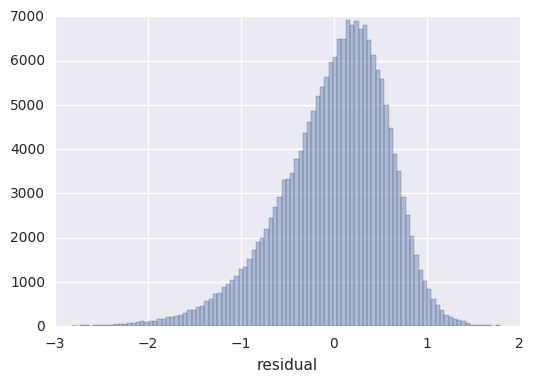

In [14]:
sns.distplot(plotDf.residual, bins=100, kde=False)
# plt.xlim(-4e5,4e5)

#### Linear model with cross-validation

In [15]:
l1s = (1-np.logspace(0,-2,num=5))
enetCV = ElasticNetCV(l1_ratio=l1s, alphas=np.logspace(-8,2,num=10), max_iter=5000)
enetCV.fit(X, target)

# print results
print(enetCV.alphas_)
print(enetCV.alpha_)
print(l1s)
print(enetCV.l1_ratio_)
pd.Series(enetCV.coef_, index=X.columns)

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:450: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


[  1.00000000e+02   7.74263683e+00   5.99484250e-01   4.64158883e-02
   3.59381366e-03   2.78255940e-04   2.15443469e-05   1.66810054e-06
   1.29154967e-07   1.00000000e-08]
1.29154966501e-07
[ 0.          0.68377223  0.9         0.96837722  0.99      ]
0.0


omamassa                                                        0.123649
iskutilavuus                                                   -0.012040
suurinNettoteho                                                 0.031037
kayttoonottoVuosi                                              -0.117731
ensirekVuosi                                                    0.029511
usageDays                                                       0.247521
ajoneuvoryhma_Matkailuauto                                     -0.840071
ajoneuvoryhma_NA                                                0.041338
kayttovoima_Bensiini                                           -0.433115
kayttovoima_Bensiini/CNG                                       -0.157865
kayttovoima_Bensiini/Etanoli                                   -0.484487
kayttovoima_Bensiini/Sähkö                                     -0.362155
kayttovoima_CNG                                                -0.293074
kayttovoima_Dieselöljy                             

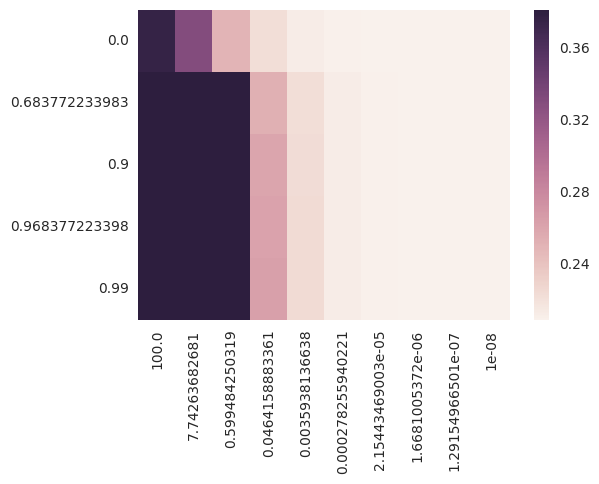

In [16]:
aa = pd.DataFrame(enetCV.mse_path_.mean(axis=2), index=l1s, columns=enetCV.alphas_)
sns.heatmap(aa)

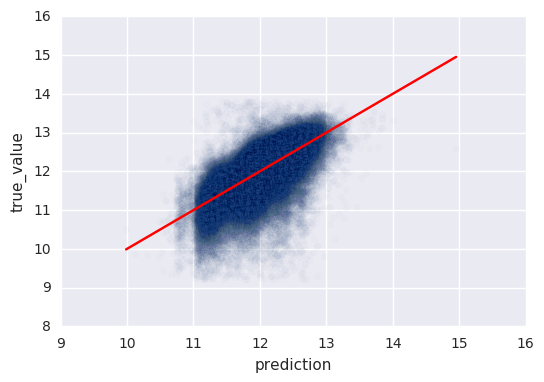

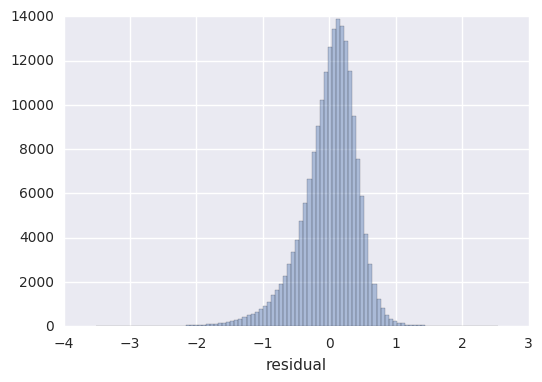

In [17]:
# Plot the prediction vs. true values
plotDf = pd.DataFrame({'prediction': enetCV.predict(X), 'true_value': target})
plotDf['residual'] = plotDf.true_value-plotDf.prediction
zz = np.array([plotDf.prediction.min(), plotDf.prediction.max()])
#fig, axes = plt.subplots()
plotDf.plot.scatter(x='prediction', y='true_value', alpha=.02)
plt.plot(zz, zz, 'r-')
plt.show()
sns.distplot(plotDf.residual, bins=100, kde=False)
plt.show()

### Gradient boosting
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor

In [18]:
gbr = ensemble.GradientBoostingRegressor(
    n_estimators=400,
    max_depth=3,
    min_samples_split=5,
    learning_rate=0.02,
    loss='lad',
    max_features='sqrt',
    verbose=1
)
gbr.fit(X, target)

      Iter       Train Loss   Remaining Time 
         1           0.4509           28.66s
         2           0.4482           25.84s
         3           0.4455           26.57s
         4           0.4433           27.21s
         5           0.4406           28.61s
         6           0.4393           29.79s
         7           0.4365           30.89s
         8           0.4342           30.86s
         9           0.4313           31.10s
        10           0.4303           30.06s
        20           0.4096           28.52s
        30           0.3940           27.93s
        40           0.3796           28.47s
        50           0.3673           26.94s
        60           0.3572           25.33s
        70           0.3484           23.85s
        80           0.3416           22.63s
        90           0.3359           21.75s
       100           0.3306           20.83s
       200           0.3058           13.34s
       300           0.2993            6.86s
       40

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.02,
             loss='lad', max_depth=3, max_features='sqrt',
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=None, subsample=1.0, verbose=1,
             warm_start=False)

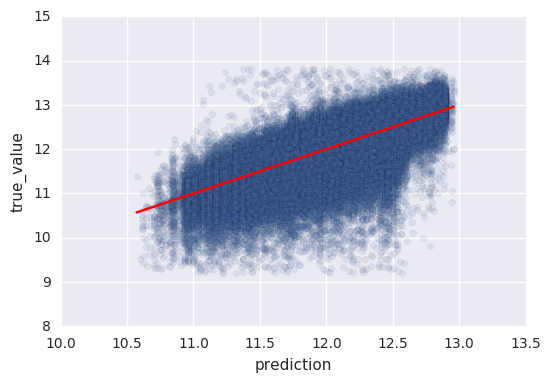

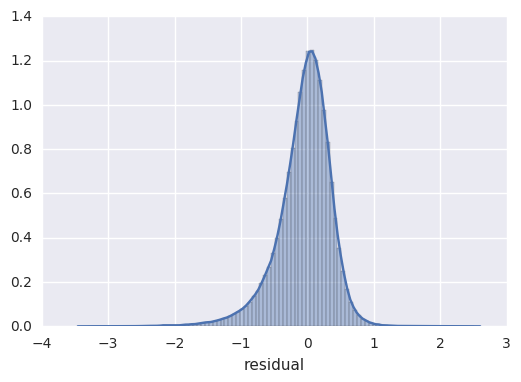

In [19]:
# Plot the prediction vs. true values
plotDf = pd.DataFrame({'prediction': gbr.predict(X), 'true_value': target})
plotDf['residual'] = plotDf.true_value-plotDf.prediction
zz = np.array([plotDf.prediction.min(), plotDf.prediction.max()])
#fig, axes = plt.subplots()
plotDf.plot.scatter(x='prediction', y='true_value', alpha=.1)
plt.plot(zz, zz, 'r-')
plt.show()
sns.distplot(plotDf.residual, bins=100, kde=True)
plt.show()

In [20]:
feature_importance = gbr.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

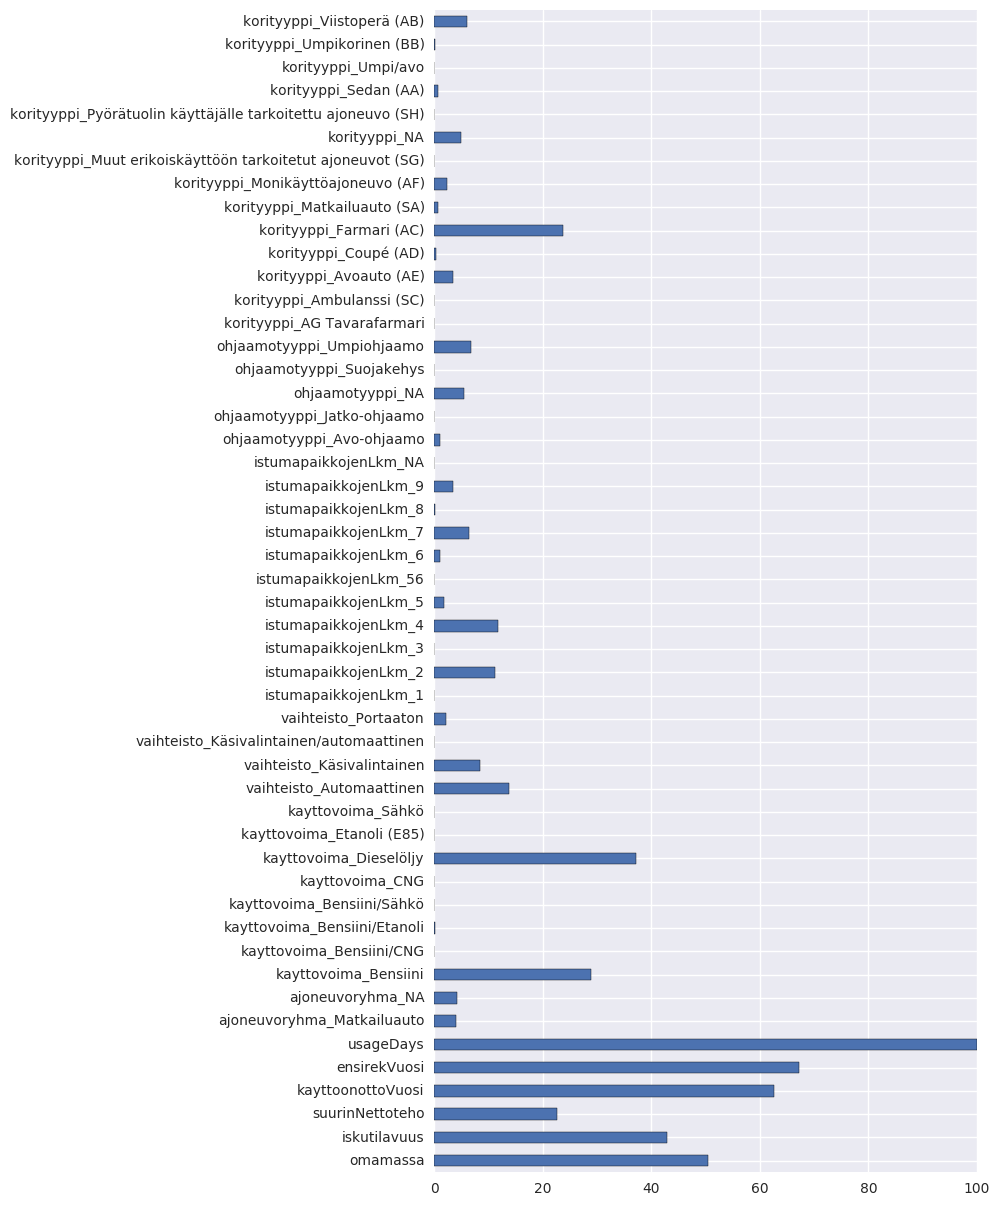

In [21]:
featDf=pd.Series(data=feature_importance, index=X.columns)
featDf.plot(kind='barh', figsize=(7, 15))

### Save the fitted model and other relevant data

In [22]:
pickle.dump(
    {
        'model': gbr, 
        'scaler': scaler, 
        'imputer': imputer, 
        'trainColumns': X.columns,
        'factorVars': factorVars,
        'numericVars': numericVars,
        'dateVars': dateVars
    }, 
    open('enet.pyobj','wb')
)